## Proposal for a one-dimensional, unbinned, spectrum format 

In [1]:
import numpy as np
import astropy.units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.data import DataStore 
from gammapy.utils.regions import list_to_compound_region
from gammapy.spectrum import (
    SpectrumDataset,
    SpectrumDatasetMaker,
    ReflectedRegionsFinder,
    ReflectedRegionsBackgroundMaker
)
import matplotlib.pyplot as plt

Let us use as an example the MAGIC DL3 data in the joint-crab project  (copied in this repo for convenience)

In [2]:
datastore = DataStore.from_dir("data/magic")
observations = datastore.get_observations()

In [3]:
# define the ON region
target_position = SkyCoord.from_name("Crab")
rad_max = np.sqrt(0.02)
on_region_radius = Angle(f"{rad_max} deg")
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

## Binned spectral data
Let us produce binned spectral data (OGIP), that we will use them for comparison

In [4]:
e_reco = np.logspace(1, 5) * u.GeV
e_true = np.logspace(1, 5) * u.GeV
# define the empty dataset
dataset_empty = SpectrumDataset.create(
    e_reco=e_reco, e_true=e_true, region=on_region
)

dataset_maker = SpectrumDatasetMaker(
    containment_correction=False,
    selection=["counts", "aeff", "edisp"],
)
        
bkg_maker = ReflectedRegionsBackgroundMaker(min_distance="40 deg")
        
for observation in observations:
    dataset = dataset_maker.run(dataset_empty, observation)
    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off.to_ogip_files("spectra/binned", overwrite=True)

## Unbinned spectral data
Now let us try to produce unbinned spectral data, as suggested in https://github.com/open-gamma-ray-astro/gamma-astro-data-formats/issues/138 the unbinned spectra should contain:

* an ON event list, containing all the events in the source region with their reconstructed energies;

* an OFF event list, containing all the events in the background region with their reconstructed energies;

* attached to the ON and OFF event lists
    - a HEADER keyword, with the ratio between the ON and OFF region exposures,
    
    - a HEADER keyword with the effective observation time.
    
* unbinned (or very fine binned) effective area as a function of true energy, at the offset of the observation, corrected with the PSF (if full enclosure IRFs are provided);

* unbinned (or very fine binned) energy migration, at the offset of the observation (alternatively resolution and bias as a function of true energy).

In [5]:
type(on_region)

regions.shapes.circle.CircleSkyRegion

In [6]:
def unbinned_spectrum_maker(observation, on_region, min_distance="40 deg"):
    """function to produce unbinned spectral data
    
    Parameters
    ----------
    observation : `~gammapy.data.observations.DataStoreObservation`
        observation on which to perform the signal / bakground separation
    on_region : `~regions.shapes.circle.CircleSkyRegion`
        sky region containing the source 
    min_distance : string
        angular distance in degrees between different wobbles
    """
    # let us use gammapy ReflectedRegionsFinder to define the ON and OFF regions
    obs_id = observation.obs_id
    print(f"reducing observation {obs_id} to unbinned spectral format")
    pointing = observation.pointing_radec
    finder = ReflectedRegionsFinder(region=on_region, center=pointing, min_distance=min_distance)
    finder.run()
    finder.plot()
    plt.show()
    # filter the ON and OFF events using the finder results 
    # code borrowed from ReflectedRegionsBackgroundMaker
    wcs = finder.reference_map.geom.wcs
    region_union = list_to_compound_region(finder.reflected_regions)
    on_events = observation.events.select_region(on_region, wcs)
    off_events = observation.events.select_region(region_union, wcs)
    # declare very fine bins for the IRFs, evaluate IRFs the observation offset (0.4 deg in this case)
    e_true = np.logspace(1, 5, 300) * u.GeV
    e_reco = np.logspace(1, 5, 300) * u.GeV
    aeff_table = observation.aeff.to_effective_area_table(offset="0.4 deg", energy=e_true)
    edisp_table = observation.edisp.to_energy_dispersion(offset="0.4 deg", e_true=e_true, e_reco=e_reco)
    aeff_table.plot()
    plt.show()
    edisp_table.plot_matrix()
    plt.show()
    # store this information in a FITS file, starting with the ON and OFF event lists
    # append some useful meta data
    # ON events
    on_events_meta = {
        "name": "ON_EVENTS",
        "exposure": observation.observation_live_time_duration.to("s").value,
        "obs_id": obs_id,
        "regions": 1
    }
    on_events_table = Table(
        [on_events.energy],
        names=("energy",),
        meta=on_events_meta 
    )
    on_events_table.write(f"spectra/unbinned/on_events_{obs_id}.fits", overwrite=True)
    # OFF events
    off_events_meta = {
        "name": "OFF_EVENTS",
        "exposure": observation.observation_live_time_duration.to("s").value,
        "obs_id": obs_id,
        "regions": 3
    }
    off_events_table = Table(
        [off_events.energy],
        names=("energy",),
        meta=on_events_meta 
    )
    off_events_table.write(f"spectra/unbinned/off_events_{obs_id}.fits", overwrite=True)
    # IRFs 
    aeff_table.write(f"spectra/unbinned/aeff_{obs_id}.fits", overwrite=True)
    edisp_table.write(f"spectra/unbinned/edisp_{obs_id}.fits", overwrite=True)

reducing observation 5029747 to unbinned spectral format


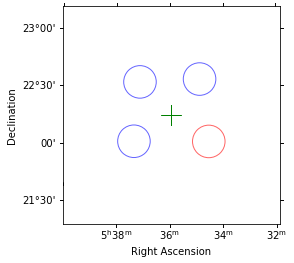

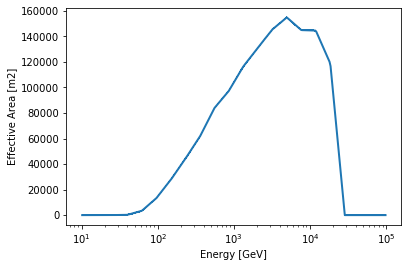

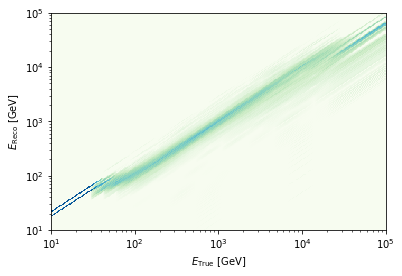

reducing observation 5029748 to unbinned spectral format


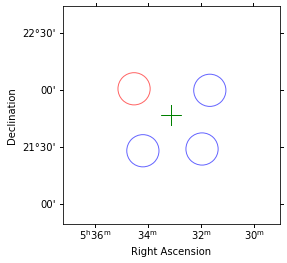

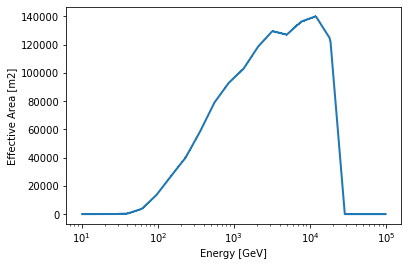

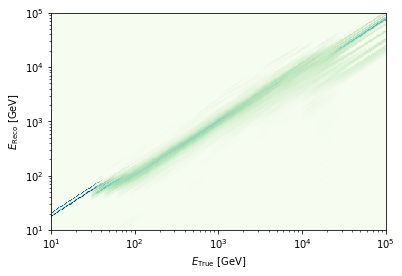

In [7]:
# produce the unbinned spectral files
for observation in observations:
    unbinned_spectrum_maker(observation, on_region)